In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np 
import pickle

from sklearn.decomposition import PCA
from get_AM4_data_lw import  get_AM4_data_lw

In [2]:
# def get_AM4_data_lw(out_filelist, inp_filelist, condition='csaf', month_sel = None, day_sel = None):
#     # sample data by month and day
#     if month_sel == None:
#         month_sel = [1,2,3,4,5,6,7,8,9,10,11,12]
#     if day_sel == None: 
#         day_sel = [1,11,21]
    
#     input_array_list = []
#     output_array_list = []

#     id_list_drop = []
#     input_array_list_drop = []
#     for tile_i in range(len(out_filelist)): 
#         # read data from files  
#         ds = xr.open_dataset(inp_filelist[tile_i])
#         ds_inp = ds.isel(time=ds.time.dt.month.isin(month_sel)).isel(time=ds.time.dt.day.isin(day_sel))
#         ds = xr.open_dataset(out_filelist[tile_i])
#         ds_out = ds.isel(time=ds.time.dt.month.isin(month_sel)).isel(time=ds.time.dt.day.isin(day_sel))
#         var_ps = ds_inp['level_pressure'].isel(phalf=-1) # this will be included in input by default
#         inp_var_name_csaf   = ['level_temperature'  ,'surface_temperature', 'water_vapor' ,'ozone' ]
#         inp_var_name_cloud  = ['stratiform_droplet_number' ,'stratiform_cloud_fraction' ,
#                                'stratiform_liquid_content' ,'stratiform_ice_content'    ,
#                                'shallow_droplet_number'    ,'shallow_cloud_fraction'    ,
#                                'shallow_liquid_content'    ,'shallow_ice_content'       ,
#                                'strat_size_drop'           ,'shallow_size_drop'          ]
#         # inp_var_name_aersol   = ['stratiform_droplet_number' ,'stratiform_cloud_fraction' ,
#         #                        'stratiform_liquid_content' ,'stratiform_ice_content'    ,
#         #                        'shallow_droplet_number'    ,'shallow_cloud_fraction'    ,
#         #                        'shallow_liquid_content'    ,'shallow_ice_content'       ,
#         #                        'strat_size_drop'           ,'shallow_size_drop'          ]
#         out_var_name_csaf   = ['rldscsaf'  ,'rlus', 'rlutcsaf' ,'tntrlcsaf' ]
#         out_var_name_af     = ['rldsaf'  ,'rlus', 'rlutaf' ,'tntrlaf' ]
#         out_var_name_cs     = ['rldscs'  ,'rlus', 'rlutcs' ,'tntrlcs' ]
#         if condition == 'csaf':
#             inp_var_name = inp_var_name_csaf
#             out_var_name = out_var_name_csaf
#         elif condition == 'af':
#             inp_var_name = inp_var_name_csaf + inp_var_name_cloud
#             out_var_name = out_var_name_af
#         else: raise Exception(f"condition {condition} is not configured")
        
#         input_sf =[[ var_ps.stack(txy=("time","grid_xt", "grid_yt")).values],]
#         for _var in inp_var_name:  # for all vars
#             tmp = ds_inp[_var].stack(txy=("time","grid_xt", "grid_yt")).fillna(0).values
#             if len(tmp.shape)==1:
#                 input_sf.append(tmp[None,:]) # addtional dim
#             else:
#                 input_sf.append(tmp)
#         input_sf = np.concatenate(input_sf)
#         output_sf = []
#         for _var in out_var_name:  # for all vars
#             tmp = ds_out[_var].stack(txy=("time","grid_xt", "grid_yt")).fillna(0).values
#             if len(tmp.shape)==1:
#                 output_sf.append(tmp[None,:]) # addtional dim
#             else:
#                 output_sf.append(tmp)
#         output_sf = np.concatenate(output_sf) 
#         input_array_list.append(input_sf)
#         output_array_list.append(output_sf)
#     #concatenate and transpose the matrix
#     input_array_list  = np.concatenate( input_array_list,axis=1).T
#     output_array_list = np.concatenate(output_array_list,axis=1).T
#     return input_array_list, output_array_list

In [3]:
# out_filelist = [f'./AM4_v1/20000101.fluxes.tile{_}.nc' for _ in range(1,7)]
# inp_filelist = [f'./AM4_v1/20000101.new_offline_input.tile{_}.nc' for _ in range(1,7)]
out_filelist = [f'/scratch/gpfs/rm5768/ml/20000101.fluxes.tile{_}.nc' for _ in range(1,7)]
inp_filelist = [f'/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile{_}.nc' for _ in range(1,7)]
inp_filelist, out_filelist

(['/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile1.nc',
  '/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile2.nc',
  '/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile3.nc',
  '/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile4.nc',
  '/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile5.nc',
  '/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile6.nc'],
 ['/scratch/gpfs/rm5768/ml/20000101.fluxes.tile1.nc',
  '/scratch/gpfs/rm5768/ml/20000101.fluxes.tile2.nc',
  '/scratch/gpfs/rm5768/ml/20000101.fluxes.tile3.nc',
  '/scratch/gpfs/rm5768/ml/20000101.fluxes.tile4.nc',
  '/scratch/gpfs/rm5768/ml/20000101.fluxes.tile5.nc',
  '/scratch/gpfs/rm5768/ml/20000101.fluxes.tile6.nc'])

In [20]:
# xr.open_dataset(inp_filelist[1])
# xr.open_dataset(out_filelist[1])
# xr.open_dataset(inp_filelist[1]).strat_size_drop[0,-1].fillna(0).min()

In [5]:
%%time 
# input_array_list, output_array_list = get_AM4_data_lw(out_filelist, inp_filelist, condition='af',)
input_array_list, output_array_list = get_AM4_data_lw(out_filelist, inp_filelist, condition='csaf',)
data_info = 'longwave clear sky, aersol free, AM4 1 year data (2000 level)' 

Data selection:
Month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
Day: [1, 11, 21]
CPU times: user 12.9 s, sys: 9.54 s, total: 22.4 s
Wall time: 1min 5s


In [6]:
input_array_list.shape,output_array_list.shape

((15925248, 102), (15925248, 36))

# Checking data feature

In [7]:
def data_std_normalization(input_array, output_array, nomral_para = None):
    ###################################################### 
    if nomral_para == None:
        ## normalization based on data std
        input_scale     = input_array.std(axis=0)
        input_offset    = input_array.mean(axis=0)
        # check not varying input
        if np.any(np.isclose(input_scale,0)):
            print(f'Warning: {np.isclose(input_scale,0).sum()} input feature(s) is fixed!')
            input_scale     = np.where(np.isclose(input_scale,0), 1, input_scale)  
        input_scale     = 1/input_scale
        output_scale    = output_array.std(axis=0)
        output_offset   = output_array.mean(axis=0)
        # check not varying input
        if np.any(np.isclose(output_scale,0)):
            print(f'Warning: {np.isclose(output_scale,0).sum()} output feature(s) is fixed!')
            output_scale     = np.where(np.isclose(output_scale,0), 1, output_scale)  
        output_scale    = 1/output_scale
        nomral_para = {'input_scale'   : input_scale, 
                       'input_offset'  : input_offset,
                       'output_scale'  : output_scale,
                       'output_offset' : output_offset} 
    # do normalization
    input_array  = (input_array  - nomral_para['input_offset' ])*nomral_para['input_scale' ]
    output_array = (output_array - nomral_para['output_offset'])*nomral_para['output_scale']
    return nomral_para, input_array, output_array 
nomral_para, input_array_nor, output_array_nor = \
data_std_normalization(input_array_list, output_array_list)

# Plot scaled INPUT and OUTPUT

In [8]:
#randomly sample the columns
rd_id = np.random.randint(0,output_array_nor.shape[0],5000)

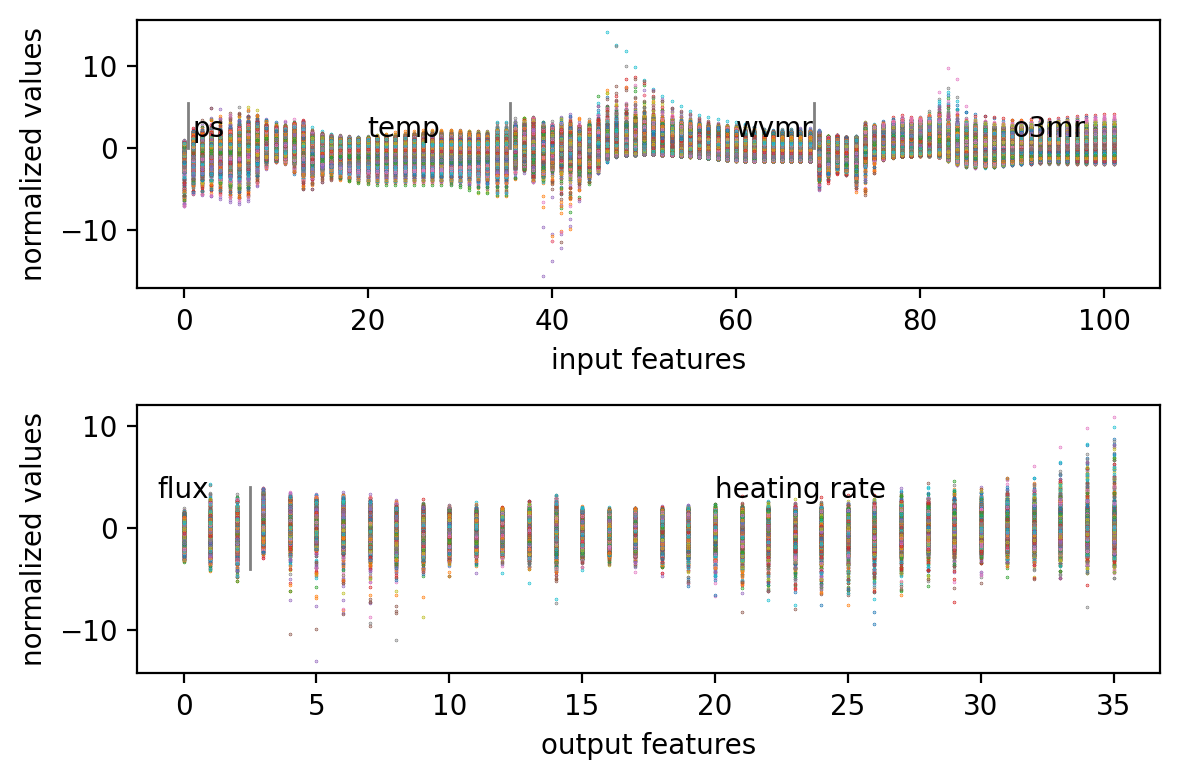

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,4),dpi=200) 

ax = axs[0]
ax.plot(input_array_nor[rd_id,:].T,'.',markersize=0.5)
ax.set_xlabel('input features')
ax.set_ylabel('normalized values')
ax.text(1,1.3,'ps')
ax.plot([0+  0.5, 0+   0.5],[0,5.5],linewidth = 1,color='grey')
ax.text( 10+ 10,   1.3,'temp')
ax.plot([0+ 35.5, 0+  35.5],[0,5.5],linewidth = 1,color='grey')
ax.text( 10+ 50,   1.3,'wvmr')
ax.plot([0+ 68.5, 0+  68.5],[0,5.5],linewidth = 1,color='grey')
ax.text( 10+ 80,   1.3,'o3mr') 
ax = axs[1]
ax.plot(output_array_nor[rd_id,:].T,'.',markersize=0.5)
ax.set_xlabel('output features')
ax.set_ylabel('normalized values') 
ax.text(-1,3,'flux')
ax.plot([2.5,2.5],[-4,4],linewidth = 1,color='grey')
ax.text(20,3,'heating rate') 
fig.tight_layout()
fig.show()

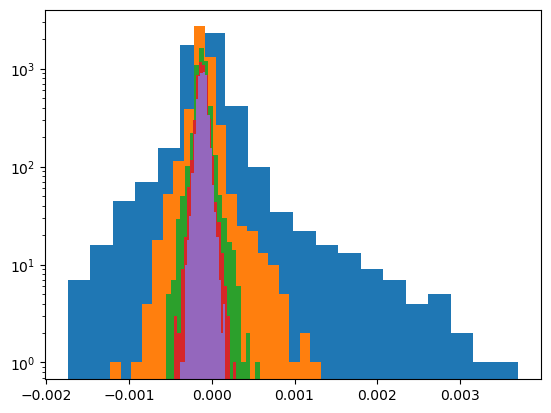

In [10]:
plt.hist(output_array_list[rd_id,-1]*5,bins=20)
plt.hist(output_array_list[rd_id,-2]*5,bins=20)
plt.hist(output_array_list[rd_id,-3]*5,bins=20)
plt.hist(output_array_list[rd_id,-4]*5,bins=20)
plt.hist(output_array_list[rd_id,-5]*5,bins=20)
plt.yscale('log')
# plt.xscale('symlog')
# plt.plot([-1,-1],[0,2000])

# PCA analysis 

In [11]:
#randomly sample the columns
rd_id_more = np.random.randint(0,input_array_nor.shape[0],100000)

In [12]:
X = np.concatenate((input_array_nor[rd_id_more,:],output_array_nor[rd_id_more,:]),axis=1)
# X = input_array_list
n_feature = input_array_nor.shape[1]+output_array_nor.shape[1]
n_components = 20
pca = PCA(n_components=n_components)
pca.fit(X)
n_pc = pca.components_
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.42125975 0.11732115 0.08179383 0.05458152 0.0409434  0.02966671
 0.02434222 0.02102984 0.01987408 0.01586216 0.01412059 0.01275133
 0.0120112  0.01153228 0.00959714 0.00837178 0.00760052 0.00706768
 0.00634351 0.0058683 ]


0.9219389900230687

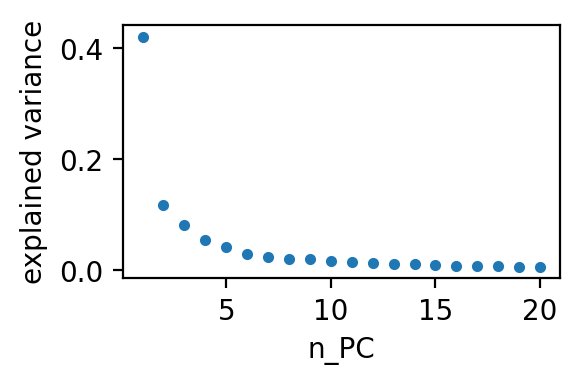

In [13]:

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3,2),dpi=200) 
ax = axs
ax.plot(np.arange(1,n_components+1),pca.explained_variance_ratio_,'.')
ax.set_xlabel('n_PC')
ax.set_ylabel('explained variance')
fig.tight_layout()
fig.show()

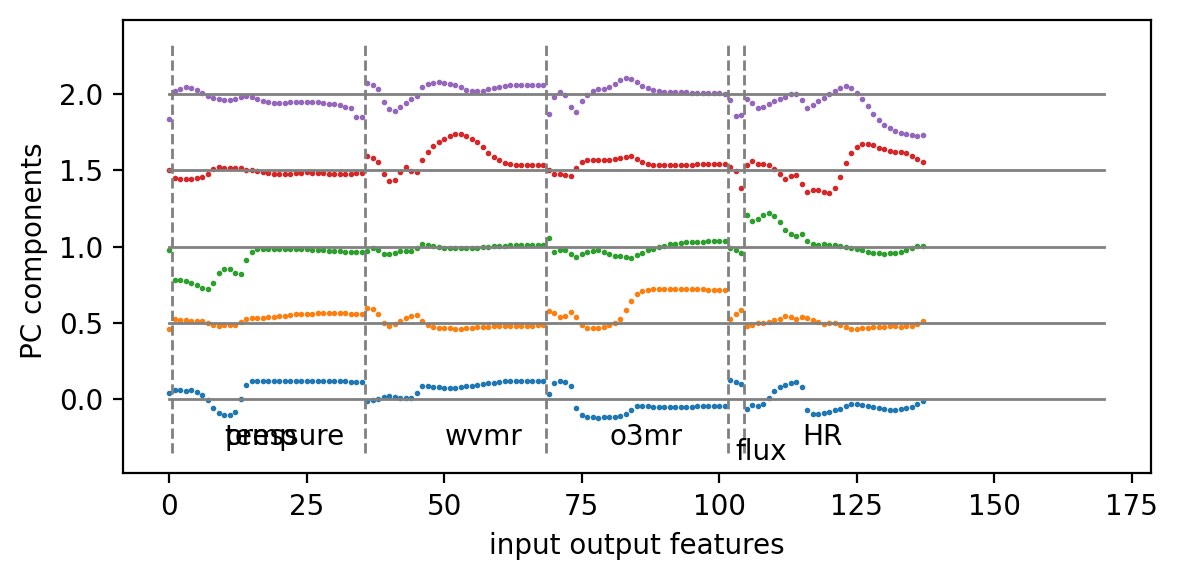

In [14]:

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,3),dpi=200) 
ax = axs 
for i in range(5):
    ax.plot(np.arange(n_feature),n_pc[i]+0.5*i,'.',markersize=2) 
    ax.plot([  0,  33+137], [0.5*i, 0.5*i],c='grey',linewidth=1) 
ax.text( 10      ,  - 0.3, 'pressure')
ax.plot([0+  0.5, 0+   0.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 10,    - 0.3, 'temp')
ax.plot([0+ 35.5, 0+  35.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 50,    - 0.3, 'wvmr')
ax.plot([0+ 68.5, 0+  68.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 80,    - 0.3, 'o3mr')
ax.plot([0+101.5, 0+ 101.5],[-0.35,2.35], '--', linewidth = 1,color='grey') 
ax.text( 0+ 103,   - 0.4, 'flux')
ax.plot([0+ 104.5,0+ 104.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 115,   - 0.3, 'HR')
ax.set_ylabel('PC components ')
ax.set_xlabel('input output features')
fig.tight_layout()
fig.show()

# Energy conservation

In [15]:
hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
A_k = hybrid_p_sigma_para.ak.values[None,:]
B_k = hybrid_p_sigma_para.bk.values[None,:]
def return_dP_AM4_plev( ps, Ak, Bk): 
    """
    ps: Pa

    return: dP of levels
    """ 
    p_int = Ak + Bk*ps 
    dp = np.diff(p_int)
    return dp

Text(0, 0.5, 'frequency')

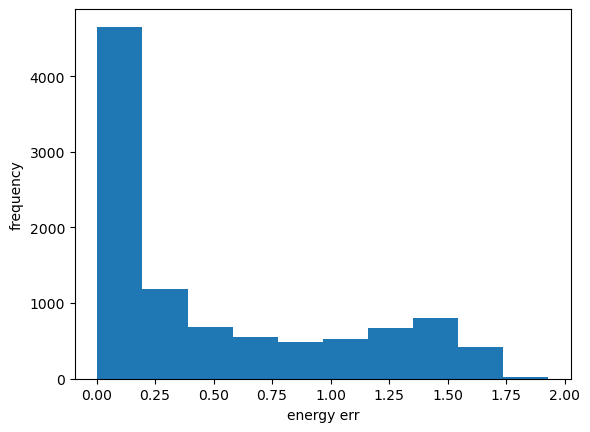

In [16]:
F_toa_up = output_array_list[:,2]
F_sfc_up = output_array_list[:,1]
F_sfc_do = output_array_list[:,0]
F_net = F_sfc_up - F_sfc_do - F_toa_up

C_p = 1004       # J/kg/K 
g   = 9.8        # m/s^2 

rd_id_e = np.random.randint(0,input_array_nor.shape[0],10000) # sample data
HR =  output_array_list[rd_id_e,3:]  
dP = return_dP_AM4_plev(input_array_list[rd_id_e,0,None],A_k,B_k)
sum_Cphr_gdp = C_p/g * (HR*dP).sum(axis=-1) 

E_err = F_net[rd_id_e]-sum_Cphr_gdp

plt.hist(E_err)
plt.xlabel('energy err')
plt.ylabel('frequency')

In [17]:
(E_err**2).mean()

0.54114836

Text(0, 0.5, 'frequency')

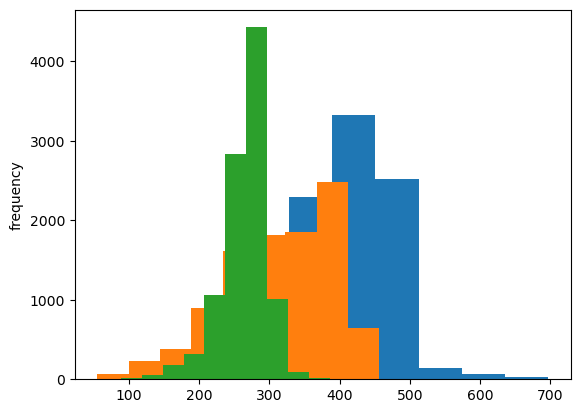

In [18]:

plt.hist(F_sfc_up[rd_id_e])
plt.hist(F_sfc_do[rd_id_e])
plt.hist(F_toa_up[rd_id_e])
# plt.xlabel('energy err') 
plt.ylabel('frequency')

(array([  39., 1283., 2419., 1519., 1563., 1542., 1004.,  437.,  145.,
          49.]),
 array([-265.69797, -244.49632, -223.29468, -202.09303, -180.89139,
        -159.68974, -138.4881 , -117.28645,  -96.08481,  -74.88316,
         -53.68152], dtype=float32),
 <BarContainer object of 10 artists>)

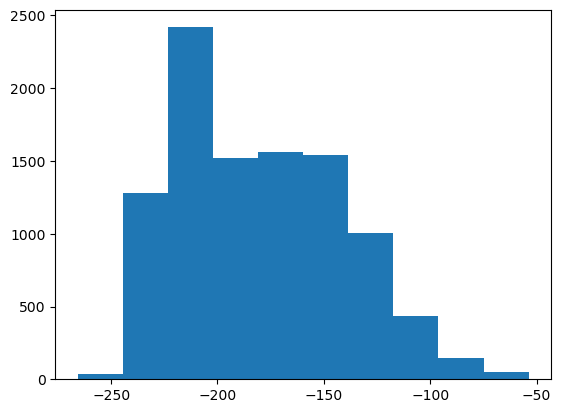

In [19]:

plt.hist(F_net[rd_id_e])

In [27]:
out =  xr.open_dataset(out_filelist[1]).isel(time=np.arange(20))
inp =  xr.open_dataset(inp_filelist[1]).isel(time=np.arange(20))

In [72]:
F_toa_up = out.rlutaf.stack(txy=['time','grid_yt','grid_xt']).values
F_sfc_up = out.rlus.stack(txy=['time','grid_yt','grid_xt']).values
F_sfc_do = out.rldsaf.stack(txy=['time','grid_yt','grid_xt']).values
F_do = out.rldaf.stack(txy=['time','grid_yt','grid_xt']).values
F_up = out.rluaf.stack(txy=['time','grid_yt','grid_xt']).values

In [73]:
(F_do[-1,:]-F_sfc_do).std(), (F_up[-1,:]-F_sfc_up).std(),(F_up[0,:]-F_toa_up).std()

(0.0, 0.02557444, 0.0)

In [65]:
F_toa_up = F_up[0,:]
F_sfc_up = F_up[-1,:]
F_sfc_do = F_do[-1,:]

In [69]:

F_net = F_sfc_up - F_sfc_do - F_toa_up
HR = out.tntrlaf .stack(txy=['time','grid_yt','grid_xt']).values
P = inp.level_pressure.stack(txy=['time','grid_yt','grid_xt'])
dP = P[1:,:].values - P[:-1,:].values

In [70]:
dP.shape, F_net.shape, HR.shape

((33, 184320), (184320,), (33, 184320))

0.0075042215


Text(0, 0.5, 'frequency')

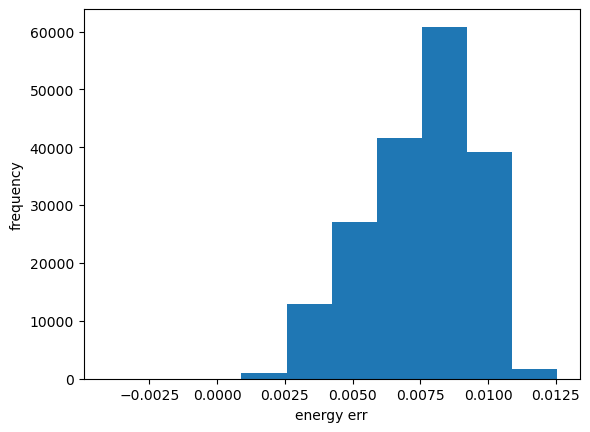

In [71]:
C_p = 1004       # J/kg/K 
g   = 9.8        # m/s^2 

sum_Cphr_gdp = C_p/g * (HR*dP).sum(axis=0) 

E_err = F_net-sum_Cphr_gdp
print(abs(E_err).mean())
plt.hist(E_err)
plt.xlabel('energy err')
plt.ylabel('frequency')